TV-Regularized Sparse-View CT Reconstruction (Multiple Projectors)
==================================================================

This example demonstrates solution of a sparse-view CT reconstruction
problem with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and
$\mathbf{x}$ is the desired image. The solution is computed and compared
for all three 2D CT projectors available in scico, using a sinogram
computed with the astra projector.

In [1]:
import numpy as np

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray import XRayTransform2D, astra, svmbir
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(1234)
x_gt = snp.array(discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N))

det_count = N
det_spacing = np.sqrt(2)

Define CT geometry and construct array of (approximately) equivalent projectors.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
projectors = {
    "astra": astra.XRayTransform2D(
        x_gt.shape, det_count, det_spacing, angles - np.pi / 2.0
    ),  # astra
    "svmbir": svmbir.XRayTransform(
        x_gt.shape, 2 * np.pi - angles, det_count, delta_pixel=1.0, delta_channel=det_spacing
    ),  # svmbir
    "scico": XRayTransform2D((N, N), angles, det_count=det_count, dx=1 / det_spacing),  # scico
}

Compute common sinogram using astra projector.

In [4]:
A = projectors["astra"]
noise = np.random.normal(size=(n_projection, det_count)).astype(np.float32)
y = A @ x_gt + 2.0 * noise

Construct initial solution for regularized problem.

In [5]:
x0 = A.fbp(y)

Solve the same problem using the different projectors.

In [6]:
print(f"Solving on {device_info()}")
x_rec, hist = {}, {}
for p in projectors.keys():
    print(f"\nSolving with {p} projector")

    # Set up ADMM solver object.
    λ = 2e1  # L1 norm regularization parameter
    ρ = 1e3  # ADMM penalty parameter
    maxiter = 100  # number of ADMM iterations
    cg_tol = 1e-4  # CG relative tolerance
    cg_maxiter = 50  # maximum CG iterations per ADMM iteration

    # The append=0 option makes the results of horizontal and vertical
    # finite differences the same shape, which is required for the L21Norm,
    # which is used so that g(Cx) corresponds to isotropic TV.
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    g = λ * functional.L21Norm()
    A = projectors[p]
    f = loss.SquaredL2Loss(y=y, A=A)

    # Set up the solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
        itstat_options={"display": True, "period": 5},
    )

    # Run the solver.
    solver.solve()
    hist[p] = solver.itstat_object.history(transpose=True)
    x_rec[p] = solver.x

    if p == "scico":
        x_rec[p] = x_rec[p] * det_spacing  # to match ASTRA's scaling

Solving on CPU

Solving with astra projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.47e+00  1.149e+07  3.238e+02  1.101e+05     24  9.490e-05


   5  5.17e+00  3.482e+06  3.856e+01  4.086e+04     11  9.840e-05


  10  7.92e+00  2.305e+06  2.847e+01  2.653e+04     10  8.830e-05


  15  1.07e+01  1.757e+06  2.971e+01  2.235e+04     10  8.097e-05


  20  1.34e+01  1.359e+06  3.489e+01  1.999e+04     10  8.641e-05


  25  1.61e+01  1.050e+06  3.731e+01  1.764e+04     11  8.754e-05


  30  1.91e+01  8.173e+05  3.671e+01  1.517e+04     11  9.478e-05


  35  2.20e+01  6.491e+05  3.353e+01  1.279e+04     11  9.694e-05


  40  2.49e+01  5.310e+05  2.944e+01  1.063e+04     11  9.095e-05


  45  2.77e+01  4.493e+05  2.522e+01  8.772e+03     10  9.265e-05


  50  3.03e+01  3.931e+05  2.187e+01  7.212e+03      9  9.826e-05


  55  3.27e+01  3.546e+05  1.864e+01  5.915e+03      8  9.748e-05


  60  3.50e+01  3.282e+05  1.546e+01  4.864e+03      8  9.491e-05


  65  3.71e+01  3.101e+05  1.332e+01  3.976e+03      7  9.259e-05


  70  3.91e+01  2.978e+05  1.129e+01  3.261e+03      7  8.916e-05


  75  4.09e+01  2.893e+05  9.067e+00  2.691e+03      6  9.509e-05


  80  4.27e+01  2.834e+05  8.083e+00  2.202e+03      5  9.198e-05


  85  4.43e+01  2.793e+05  6.681e+00  1.814e+03      5  9.086e-05


  90  4.57e+01  2.765e+05  5.781e+00  1.501e+03      3  9.629e-05


  95  4.72e+01  2.744e+05  4.596e+00  1.288e+03      4  9.698e-05


  99  4.83e+01  2.732e+05  4.040e+00  1.131e+03      4  9.131e-05

Solving with svmbir projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  6.51e+00  7.458e+06  3.238e+02  5.618e+04     19  8.754e-05


   5  2.81e+01  3.938e+06  2.547e+01  3.259e+04      9  9.958e-05


  10  4.47e+01  2.895e+06  2.374e+01  2.628e+04      8  9.728e-05


  15  6.05e+01  2.264e+06  2.599e+01  2.328e+04      8  9.055e-05


  20  7.63e+01  1.795e+06  2.953e+01  2.123e+04      8  9.788e-05


  25  9.36e+01  1.421e+06  3.267e+01  1.928e+04      9  9.846e-05


  30  1.11e+02  1.124e+06  3.391e+01  1.722e+04     10  8.899e-05


  35  1.30e+02  8.933e+05  3.317e+01  1.512e+04     10  9.764e-05


  40  1.49e+02  7.189e+05  3.123e+01  1.306e+04     10  9.825e-05


  45  1.68e+02  5.905e+05  2.845e+01  1.112e+04     10  9.373e-05


  50  1.87e+02  4.979e+05  2.563e+01  9.358e+03     10  9.029e-05


  55  2.04e+02  4.322e+05  2.234e+01  7.831e+03      9  9.533e-05


  60  2.21e+02  3.860e+05  1.933e+01  6.494e+03      9  8.741e-05


  65  2.37e+02  3.542e+05  1.707e+01  5.333e+03      8  9.222e-05


  70  2.52e+02  3.325e+05  1.413e+01  4.380e+03      8  8.734e-05


  75  2.65e+02  3.177e+05  1.219e+01  3.575e+03      7  8.938e-05


  80  2.78e+02  3.076e+05  9.645e+00  2.953e+03      6  9.420e-05


  85  2.90e+02  3.006e+05  8.425e+00  2.429e+03      5  9.525e-05


  90  3.01e+02  2.958e+05  6.993e+00  1.997e+03      5  9.289e-05


  95  3.11e+02  2.925e+05  6.352e+00  1.619e+03      5  8.778e-05


  99  3.19e+02  2.906e+05  4.822e+00  1.415e+03      4  9.618e-05

Solving with scico projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.08e+00  9.037e+06  3.238e+02  8.782e+04     21  8.275e-05


   5  1.26e+01  3.606e+06  2.971e+01  3.393e+04     10  8.207e-05


  10  1.99e+01  2.686e+06  2.290e+01  2.473e+04      8  9.904e-05


  15  2.64e+01  2.165e+06  2.440e+01  2.213e+04      7  9.835e-05


  20  3.34e+01  1.746e+06  2.867e+01  2.066e+04      8  9.480e-05


  25  4.09e+01  1.389e+06  3.258e+01  1.914e+04      9  8.682e-05


  30  4.85e+01  1.091e+06  3.474e+01  1.738e+04     10  8.015e-05


  35  5.66e+01  8.522e+05  3.463e+01  1.545e+04     10  8.646e-05


  40  6.48e+01  6.683e+05  3.323e+01  1.345e+04     10  8.277e-05


  45  7.27e+01  5.318e+05  3.041e+01  1.149e+04      9  9.685e-05


  50  8.04e+01  4.332e+05  2.728e+01  9.695e+03      9  9.685e-05


  55  8.79e+01  3.633e+05  2.383e+01  8.110e+03      9  8.630e-05


  60  9.47e+01  3.149e+05  2.114e+01  6.685e+03      9  8.619e-05


  65  1.01e+02  2.819e+05  1.753e+01  5.491e+03      8  9.947e-05


  70  1.07e+02  2.596e+05  1.472e+01  4.484e+03      6  9.702e-05


  75  1.12e+02  2.446e+05  1.250e+01  3.641e+03      6  8.922e-05


  80  1.17e+02  2.347e+05  1.065e+01  2.953e+03      6  8.383e-05


  85  1.22e+02  2.279e+05  8.301e+00  2.430e+03      5  9.532e-05


  90  1.27e+02  2.234e+05  7.263e+00  1.959e+03      5  8.197e-05


  95  1.31e+02  2.205e+05  5.869e+00  1.593e+03      5  8.551e-05


  99  1.34e+02  2.188e+05  5.162e+00  1.326e+03      4  8.715e-05


Compare reconstruction results.

In [7]:
print("Reconstruction SNR:")
for p in projectors.keys():
    print(f"  {(p + ':'):7s}  {metric.snr(x_gt, x_rec[p]):5.2f} dB")

Reconstruction SNR:
  astra:   10.63 dB
  svmbir:  10.84 dB
  scico:   10.77 dB


Display sinogram.

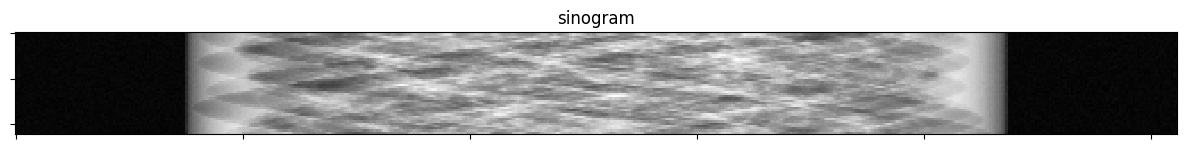

In [8]:
fig, ax = plot.subplots(nrows=1, ncols=1, figsize=(15, 3))
plot.imview(y, title="sinogram", fig=fig, ax=ax)
fig.show()

Plot convergence statistics.

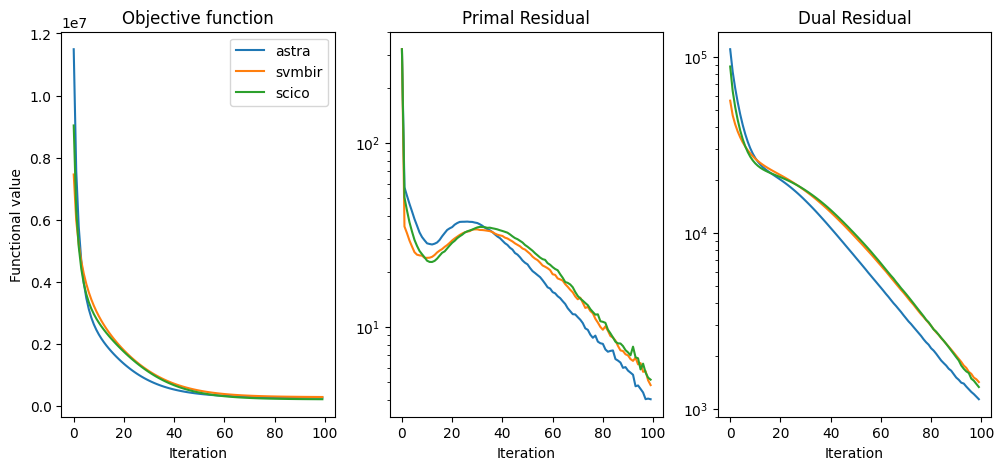

In [9]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(12, 5))
plot.plot(
    np.vstack([hist[p].Objective for p in projectors.keys()]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=projectors.keys(),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack([hist[p].Prml_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.vstack([hist[p].Dual_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[2],
)
fig.show()

Show the recovered images.

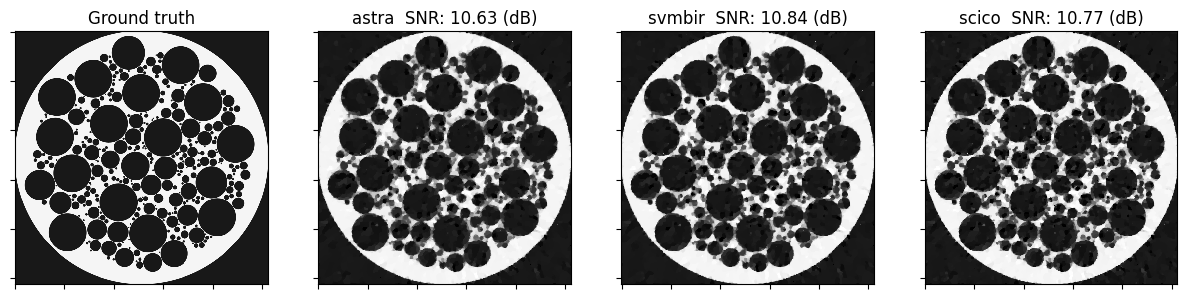

In [10]:
fig, ax = plot.subplots(nrows=1, ncols=4, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
for n, p in enumerate(projectors.keys()):
    plot.imview(
        x_rec[p],
        title="%s  SNR: %.2f (dB)" % (p, metric.snr(x_gt, x_rec[p])),
        fig=fig,
        ax=ax[n + 1],
    )
for ax in ax:
    ax.get_images()[0].set_clim(-0.1, 1.1)
fig.show()